# Set up 

In [1]:
import tellurium as te
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import aesara.tensor as at
import aesara
floatX = aesara.config.floatX
import pymc as pm
import numpy as np

import cobra
import os

from scipy import stats
import scipy as sp

from sklearn.model_selection import train_test_split

print(os.getcwd())

WARNING (aesara.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (aesara.configdefaults): g++ not detected!  Aesara will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set Aesara flags cxx to an empty string.
WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


c:\Users\user\Documents\research\BMCA-pipeline\notebooks\omitted_data


In [2]:
os.chdir('../..')
from src import BMCA, util
import emll
from emll.aesara_utils import LeastSquaresSolve
os.chdir('notebooks/omitted_data/')

In [3]:
Teusink_ant ='../../data/interim/Antimony/Simplified_Teusink_yeast.ant' 
data_file = '../../data/interim/generated_data/Simplified_Teusink_yeast_1.5.csv'
df = pd.read_csv(data_file)

# need to fix this so only rows with concentrations less than 0 are dropped 
data = df.drop(df[df.lt(0).any(axis=1)].index)

r = te.loada(Teusink_ant)
r.conservedMoietyAnalysis = True
r.steadyState()

1.5710734600032811e-15

In [4]:
enzymes = ['e_' + i for i in r.getReactionIds()]
internal = r.getFloatingSpeciesIds()
external = r.getBoundarySpeciesIds()
fluxes = ['v_' + i for i in r.getReactionIds()]

## Leaving out external metabolite data

In [5]:
holey_data = pd.concat([data[internal], data[fluxes], data[enzymes]], axis=1)

In [6]:
BIOMD64 = BMCA.BMCA(Teusink_ant, holey_data)

Model does not contain SBML fbc package information.


../../data/interim/Antimony/Simplified_Teusink_yeast_cobra.ant
Set parameter Username
Academic license - for non-commercial use only - expires 2024-10-23


Missing lower flux bound set to '-1000.0' for reaction: '<Reaction vGLK>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction vGLK>'
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction vPGI>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction vPGI>'
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction vGLYCO>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction vGLYCO>'
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction vTreha>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction vTreha>'
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction vPFK>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction vPFK>'
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction vALD>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction vALD>'
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction vGAPDH>'
Missing upper flux bound set to '1

## Running ADVI

In [7]:
def run_BayesInf(BMCA_obj, n_samp=1):
    external = r.getBoundarySpeciesIds()
    
    known_y_inds = []
    omitted_y_inds = []
    for i, y in enumerate(external):
        if y in holey_data.columns:
            known_y_inds.append(i)
        else: 
            omitted_y_inds.append(i)
    y_inds = np.hstack([known_y_inds, omitted_y_inds]).argsort()

    with pm.Model() as pymc_model:

         # Initialize elasticities
        Ex_t = pm.Deterministic('Ex', util.initialize_elasticity(BMCA_obj.Ex.to_numpy(), name='Ex'))
        Ey_t = pm.Deterministic('Ey', util.initialize_elasticity(BMCA_obj.Ey.to_numpy(), name='Ey'))
        
        # flux priors
        y_measured = pm.Normal('y_measured', mu=0, sigma=0.1, observed=BMCA_obj.vn.T)
        y_unmeasured = pm.Normal('y_unmeasured', mu=0, sigma=0.1, shape=(len(omitted_y_inds), len(BMCA_obj.vn)))

        y_t = at.concatenate([y_measured, y_unmeasured], axis=0)[y_inds, :]
        pm.Deterministic('y_t', y_t)
        
        chi_t = pm.Normal('chi_t', mu=0, sigma=0.1, observed=BMCA_obj.xn.T)
        e_t = pm.Normal('e_t', mu=1, sigma=0.1, observed=BMCA_obj.en.squeeze().T)

        likelihood = pm.Deterministic('vn', e_t * (np.ones(BMCA_obj.en.T.shape) + pm.math.dot(Ex_t,chi_t) + pm.math.dot(Ey_t,y_t)))
        v_hat_obs = pm.Normal('v_hat_obs', mu=likelihood, sigma=0.1, observed=BMCA_obj.vn.squeeze().T)
        
        N_ITERATIONS = 45000

        advi = pm.ADVI()
        tracker = pm.callbacks.Tracker(
            mean = advi.approx.mean.eval,
            std = advi.approx.std.eval
        )
        approx = advi.fit(
            n=N_ITERATIONS, 
            callbacks = [tracker],
            obj_optimizer=pm.adagrad_window(learning_rate=1E-1), 
            total_grad_norm_constraint=0.7,
            obj_n_mc=1)
        
    with sns.plotting_context('notebook', font_scale=1.2):

        fig = plt.figure(figsize=(5,4))
        plt.plot(approx.hist + 30, '.', rasterized=True, ms=1)
        # plt.ylim([-1E1, 1E3])
        plt.xlim([0, N_ITERATIONS])
        sns.despine(trim=True, offset=10)

        plt.ylabel('-ELBO')
        plt.xlabel('Iteration')
        plt.title('in vitro ADVI convergence')
        plt.tight_layout()

    if n_samp > 1:
        samples = []
        for i in range(n_samp): 
            samples.append(approx.sample(draws=1000, random_seed=i))
        return samples
    else:
        return approx.sample(draws=1000, random_seed=n_samp)


c:\Users\user\miniconda3\envs\new_Gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Finished [100%]: Average Loss = 15,632


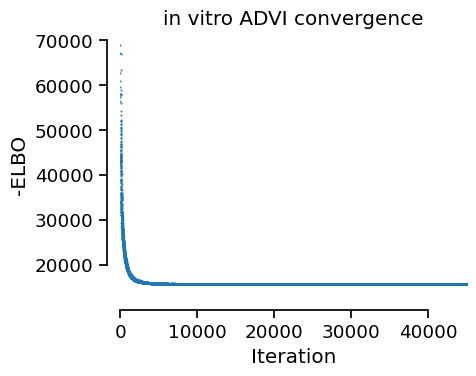

In [8]:
traces = run_BayesInf(BIOMD64, n_samp=3)

## Plotting ADVI results

In [9]:
Ex_0 = (traces[0]['posterior']['Ex']).to_numpy().squeeze()
Ex_1 = (traces[1]['posterior']['Ex']).to_numpy().squeeze()
Ex_2 = (traces[2]['posterior']['Ex']).to_numpy().squeeze()
Ex = np.concatenate([Ex_0, Ex_1, Ex_2])
med_Ex_advi = np.median(Ex, axis=0)

## Calculating FCCs

In [10]:
gtFCC = pd.DataFrame(r.getScaledFluxControlCoefficientMatrix(), index=r.getReactionIds(), columns=r.getReactionIds())

In [11]:
def estimate_CCs(BMCA_obj, Ex):
    BMCA_obj.vn[BMCA_obj.vn == 0] = 1e-6
    
    a = np.diag(BMCA_obj.en.values / BMCA_obj.vn.values)
    a = np.diag(a)
    a = a[np.newaxis,:].repeat(1000, axis=0)

    Ex_ss = a @ Ex
    As = BMCA_obj.N @ np.diag(BMCA_obj.v_star) @ Ex_ss
    bs = BMCA_obj.N @ np.diag(BMCA_obj.v_star)
    bs = bs[np.newaxis, :].repeat(1000, axis=0)
    
    As = at.as_tensor_variable(As)
    bs = at.as_tensor_variable(bs)

    def solve_aesara(A, b):
        rsolve_op = LeastSquaresSolve()
        return rsolve_op(A, b).squeeze()

    CCC, _ = aesara.scan(lambda A, b: solve_aesara(A, b),
                        sequences=[As, bs], strict=True)

    identity = np.eye(len(BMCA_obj.N.T))
    identity = identity[np.newaxis,:].repeat(1000, axis=0)
    
    FCC = (Ex_ss @ CCC.eval()) + identity
    
    return CCC.eval(), FCC


### Negative predictions

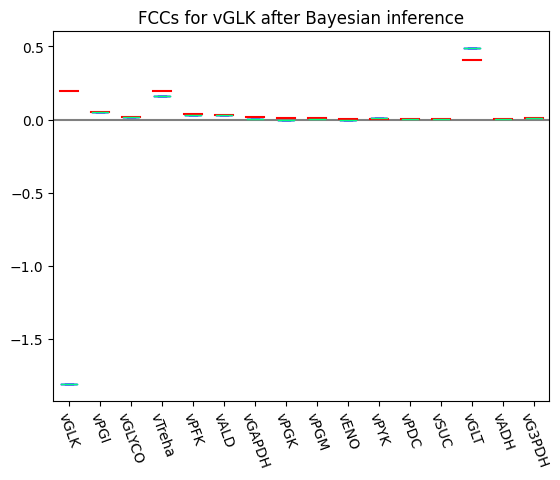

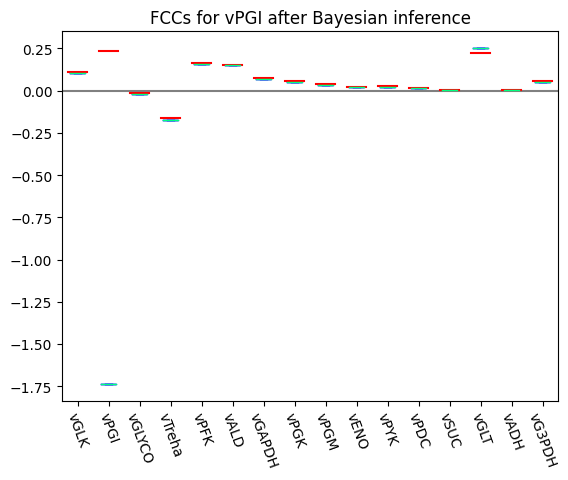

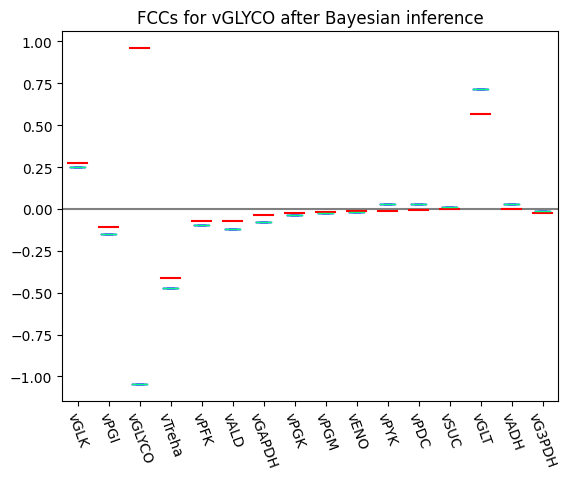

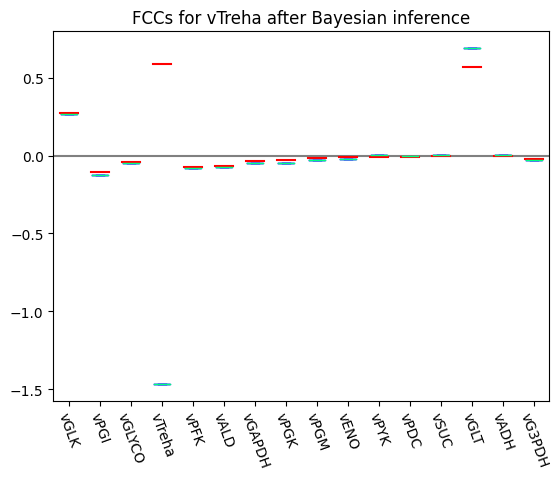

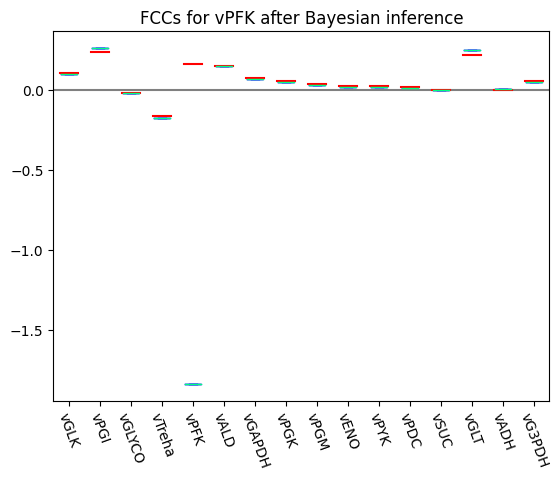

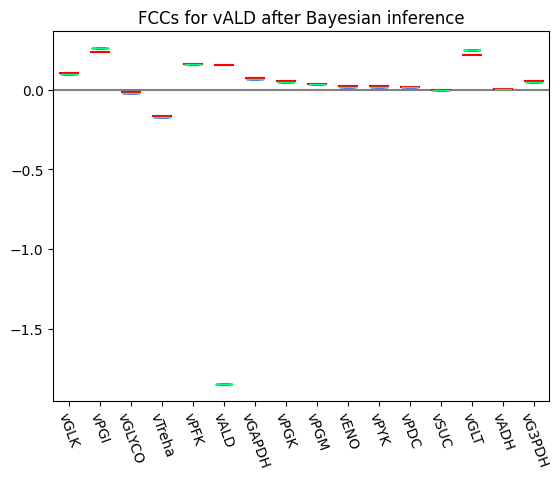

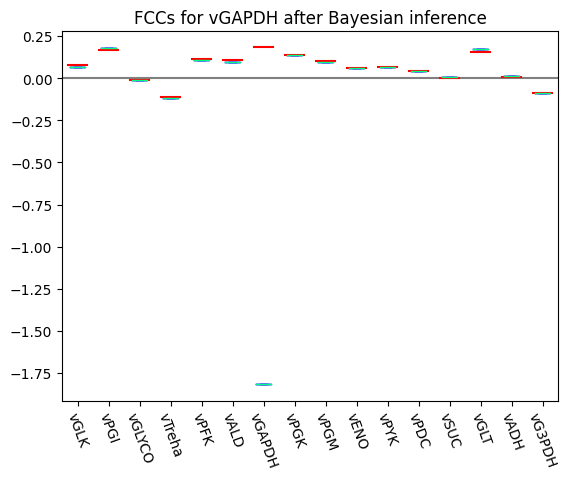

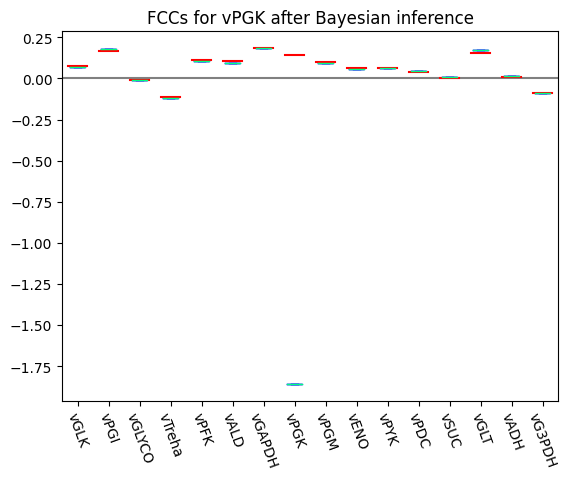

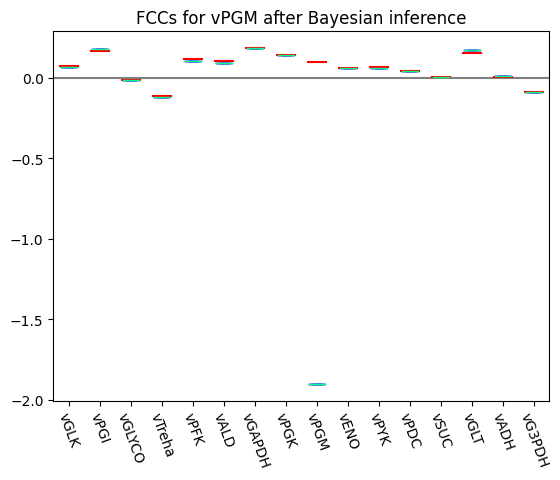

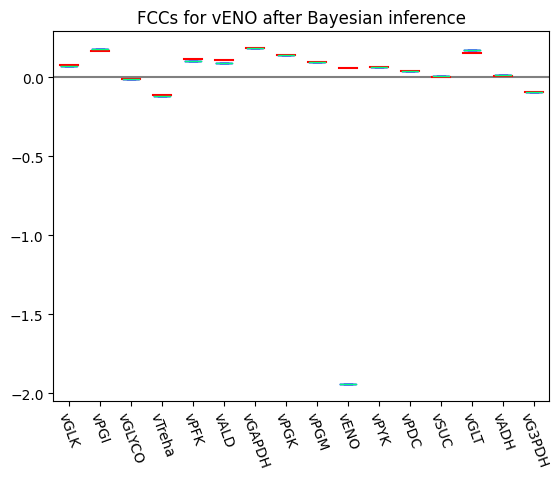

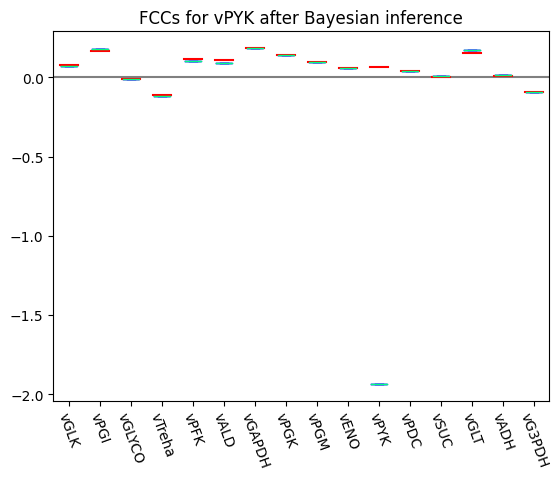

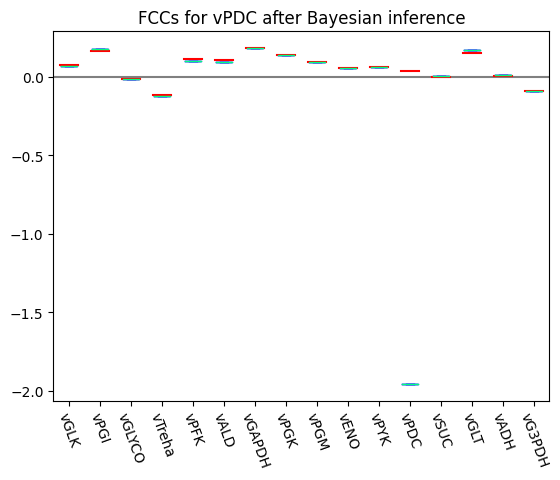

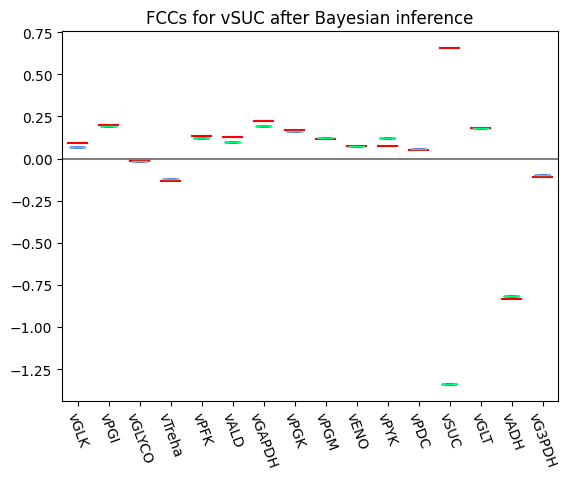

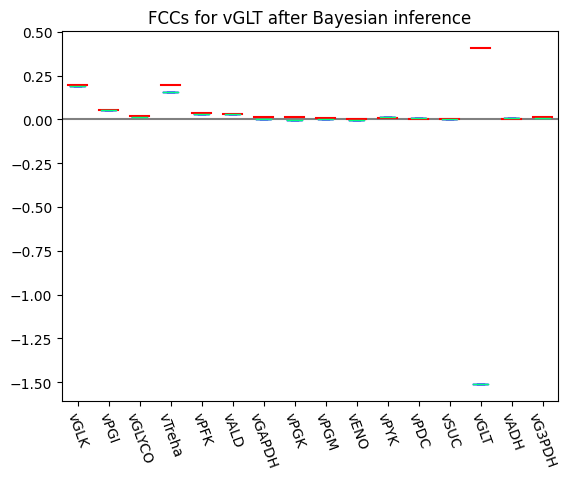

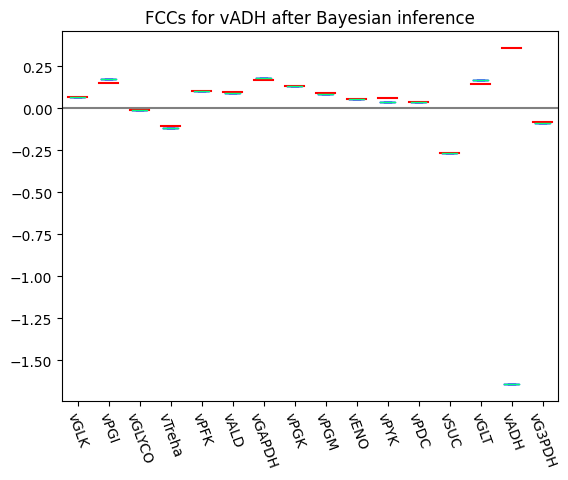

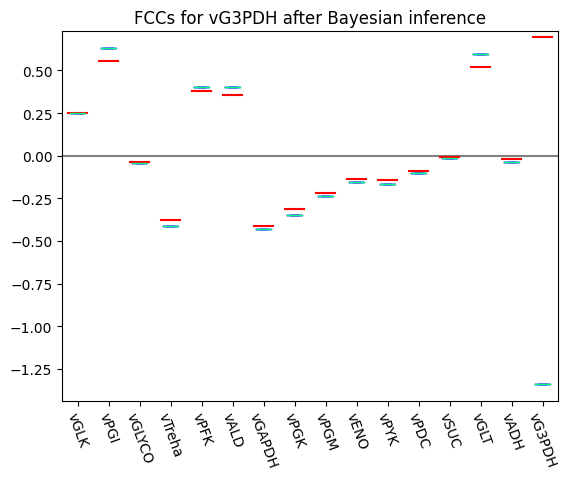

In [12]:
postCCC, postFCC = estimate_CCs(BIOMD64, med_Ex_advi)
for i,rxnID in enumerate(r.getReactionIds()):
    FCCs = -pd.DataFrame(postFCC[:,i,:], columns=r.getReactionIds())
    # FCCs = pd.DataFrame(postFCC[:,i,:], columns=r.getReactionIds())

    FCCs.plot(kind='box', colormap='winter')
    plt.title(f'FCCs for {rxnID} after Bayesian inference')
    plt.axhline(0, c='gray')

    for i,val in enumerate(gtFCC.loc[rxnID]): # .sort_index()
        plt.axhline(y = val,    # Line on y = 0.2
                xmin = (i+0.2)/len(gtFCC[rxnID]), # From the left
                xmax = (i+0.8)/len(gtFCC[rxnID]), 
                c='red') # To the right
    plt.xticks(rotation=-70)
# plt.ylim((-1,3))

## Evaluating FCC ranking

In [13]:
gtFCC=pd.DataFrame(r.getScaledFluxControlCoefficientMatrix(), columns=r.getReactionIds(), index=r.getReactionIds()).abs()
m1 = gtFCC.index.values[:, None] == gtFCC.columns.values
gtFCC = pd.DataFrame(np.select([m1], [float('Nan')], gtFCC), columns=gtFCC.columns, index=gtFCC.index)
gtFCC_rankings= gtFCC.rank(axis=1, ascending=False, na_option='keep')
gtFCC_rankings

,vGLK,vPGI,vGLYCO,vTreha,vPFK,vALD,vGAPDH,vPGK,vPGM,vENO,vPYK,vPDC,vSUC,vGLT,vADH,vG3PDH
vGLK,NaN,3.0,6.0,2.0,4.0,5.0,7.0,8.0,10.0,12.0,11.0,13.0,15.0,1.0,14.0,9.0
vPGI,5.0,NaN,13.0,3.0,2.0,4.0,6.0,7.0,9.0,11.0,10.0,12.0,15.0,1.0,14.0,8.0
vGLYCO,3.0,4.0,NaN,2.0,5.0,6.0,7.0,8.0,10.0,12.0,11.0,13.0,15.0,1.0,14.0,9.0
vTreha,2.0,3.0,6.0,NaN,4.0,5.0,7.0,8.0,10.0,12.0,11.0,13.0,15.0,1.0,14.0,9.0
vPFK,5.0,1.0,13.0,3.0,NaN,4.0,6.0,7.0,9.0,11.0,10.0,12.0,15.0,2.0,14.0,8.0
vALD,5.0,1.0,13.0,4.0,3.0,NaN,6.0,7.0,9.0,11.0,10.0,12.0,15.0,2.0,14.0,8.0
vGAPDH,9.0,1.0,13.0,5.0,4.0,6.0,NaN,3.0,7.0,11.0,10.0,12.0,15.0,2.0,14.0,8.0
vPGK,9.0,2.0,13.0,5.0,4.0,6.0,1.0,NaN,7.0,11.0,10.0,12.0,15.0,3.0,14.0,8.0
vPGM,9.0,2.0,13.0,6.0,5.0,7.0,1.0,4.0,NaN,11.0,10.0,12.0,15.0,3.0,14.0,8.0
vENO,10.0,2.0,13.0,6.0,5.0,7.0,1.0,4.0,8.0,NaN,11.0,12.0,15.0,3.0,14.0,9.0


In [14]:
postFCC_med=pd.DataFrame(np.median(postFCC, axis=0), columns=r.getReactionIds(), index=r.getReactionIds()).abs()
# m1 = gtFCC.index.values[:, None] == gtFCC.columns.values
postFCC_med = pd.DataFrame(np.select([m1], [float('Nan')], postFCC_med), columns=gtFCC.columns, index=gtFCC.index)
postFCC_med_rankings= postFCC_med.rank(axis=1, ascending=False, na_option='keep')
postFCC_med_rankings

,vGLK,vPGI,vGLYCO,vTreha,vPFK,vALD,vGAPDH,vPGK,vPGM,vENO,vPYK,vPDC,vSUC,vGLT,vADH,vG3PDH
vGLK,NaN,3.0,6.0,2.0,4.0,5.0,11.0,12.0,14.0,15.0,7.0,9.0,13.0,1.0,10.0,8.0
vPGI,5.0,NaN,12.0,2.0,3.0,4.0,6.0,8.0,9.0,11.0,10.0,13.0,15.0,1.0,14.0,7.0
vGLYCO,3.0,4.0,NaN,2.0,6.0,5.0,7.0,8.0,12.0,13.0,11.0,10.0,15.0,1.0,9.0,14.0
vTreha,2.0,3.0,8.0,NaN,4.0,5.0,7.0,6.0,10.0,11.0,14.0,13.0,15.0,1.0,12.0,9.0
vPFK,5.0,1.0,12.0,3.0,NaN,4.0,6.0,8.0,9.0,11.0,10.0,13.0,15.0,2.0,14.0,7.0
vALD,5.0,1.0,12.0,3.0,4.0,NaN,6.0,8.0,9.0,11.0,10.0,13.0,15.0,2.0,14.0,7.0
vGAPDH,9.0,1.0,14.0,4.0,5.0,7.0,NaN,3.0,6.0,11.0,10.0,12.0,15.0,2.0,13.0,8.0
vPGK,9.0,2.0,14.0,4.0,5.0,7.0,1.0,NaN,6.0,11.0,10.0,12.0,15.0,3.0,13.0,8.0
vPGM,9.0,2.0,14.0,5.0,6.0,7.0,1.0,4.0,NaN,11.0,10.0,12.0,15.0,3.0,13.0,8.0
vENO,10.0,2.0,14.0,5.0,6.0,8.0,1.0,4.0,7.0,NaN,11.0,12.0,15.0,3.0,13.0,9.0


In [15]:
for i in r.getReactionIds():
    a = gtFCC_rankings.loc[i].values
    b = postFCC_med_rankings.loc[i].values
    spcorr = stats.spearmanr(a,b,nan_policy='omit')
    print(i, spcorr)

vGLK SpearmanrResult(correlation=0.8035714285714285, pvalue=0.00030726503181250785)
vPGI SpearmanrResult(correlation=0.9892857142857141, pvalue=2.9989342571552654e-12)
vGLYCO SpearmanrResult(correlation=0.882142857142857, pvalue=1.3558210624788787e-05)
vTreha SpearmanrResult(correlation=0.9607142857142856, pvalue=1.3027489790343175e-08)
vPFK SpearmanrResult(correlation=0.9928571428571429, pvalue=2.1681214863290813e-13)
vALD SpearmanrResult(correlation=0.9892857142857141, pvalue=2.9989342571552654e-12)
vGAPDH SpearmanrResult(correlation=0.9892857142857141, pvalue=2.9989342571552654e-12)
vPGK SpearmanrResult(correlation=0.9892857142857141, pvalue=2.9989342571552654e-12)
vPGM SpearmanrResult(correlation=0.9928571428571429, pvalue=2.1681214863290813e-13)
vENO SpearmanrResult(correlation=0.9892857142857141, pvalue=2.9989342571552654e-12)
vPYK SpearmanrResult(correlation=0.9892857142857141, pvalue=2.9989342571552654e-12)
vPDC SpearmanrResult(correlation=0.9892857142857141, pvalue=2.998934257